In [28]:
################################################
# Imports                                      #
################################################
import gc
import os
import math
import time
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from data_utils import get_dataloaders

In [32]:
################################################
# Configs                                      #
################################################
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

SEED = 711
LLM = "meta-llama_Llama-3.1-8B-Instruct"
TRAIN_DATASET_PATH = f'../RepExtraction/representations/combined_8500/{LLM}_reps.json'
VAL_DATASET_PATH = f'../RepExtraction/representations/combined_4000_test/{LLM}_reps.json'

MLP_DIMS = [4096, 1024, 1024, 512, 1]
INIT_LR = 1e-3
EPOCHS = 20

Using device: cuda


In [26]:
################################################
# Model Definition                            #
################################################
class MLP(torch.nn.Module):
    def __init__(self, num_tgt_model_layers, layer_dims, dropout=0.15, mode='lin_agt'):
        super(MLP, self).__init__()
        self.mode = mode
        self.layer_dims = layer_dims
        self.num_tgt_model_layers = num_tgt_model_layers

        # learnable linear weighting for each layer
        self.layer_weights = torch.nn.Parameter(torch.ones(self.num_tgt_model_layers))

        layers_ls = [[
            torch.nn.Linear(layer_dims[i], layer_dims[i+1]),
            torch.nn.BatchNorm1d(layer_dims[i+1]),
            torch.nn.GELU(),
            torch.nn.Dropout(p=dropout)
        ] for i in range(len(layer_dims)-1)]

        # everything after the weighted-sum operation
        self.model = torch.nn.Sequential(
            *[l for layers in layers_ls for l in layers][:-3],  # excluding last 3 (BN, GELU, Dropout) if needed
        )

    def forward(self, x):
        # x: (batch_size, num_tgt_model_layers, layer_dims[0])
        # apply learnable weights to each layer
        if self.mode == 'lin_agt':
            weights = torch.softmax(self.layer_weights, dim=0)  # normalize across layers
            x = (x * weights.view(1, -1, 1)).sum(dim=1)         # shape -> (batch_size, 4096)
        
        elif self.mode == 'avg_agt':
            num_layers = x.shape[1]
            x = x.sum(dim=1)/num_layers  # simple sum across layers
        
        else:
            layer_num = self.mode.split('_')[-1]
            x = x[:, int(layer_num), :]  # select specific layer

        return self.model(x)

    def set_dropout(self, dropout):
        for module in self.model:
            if isinstance(module, torch.nn.Dropout):
                module.p = dropout

    def set_mode(self, mode):
        if mode not in ['lin_agt', 'avg_agt'] and not mode.startswith('lyr_'): 
            raise ValueError("Invalid mode. Choose from 'lin_agt', 'avg_agt', or 'lyr_{layer_number}'")
        self.mode = mode

In [27]:
################################################
# Training & Validation functions              #
################################################
def train(model, dataloader, optimizer, criterion, scheduler=None):
    model.train()
    tloss, tacc = 0, 0 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    scaler = torch.amp.GradScaler()
    start_time = time.time()
    for i, (matrices, labels) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()

        matrices = matrices.to(DEVICE)
        labels   = labels.to(DEVICE).unsqueeze(1)

        with torch.autocast(device_type=DEVICE, dtype=torch.float16):
            logits  = model(matrices)
            loss    = criterion(logits, labels.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            if scheduler is not None: scheduler.step()
            scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum((logits>0.5) == labels).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        del matrices, labels, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    tloss /= len(dataloader)
    tacc  /= len(dataloader)

    return tloss, tacc


def eval(model, dataloader, criterion=None):
    model.eval()
    vloss, vacc = 0, 0
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (matrices, labels) in tqdm(enumerate(dataloader)):
        matrices = matrices.to(DEVICE)
        labels   = labels.to(DEVICE).unsqueeze(1)

        with torch.inference_mode():
            logits  = model(matrices)
            loss    = criterion(logits, labels.float())

        vloss += loss.item()
        vacc  += torch.sum((logits>0.5) == labels).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        del matrices, labels, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(dataloader)
    vacc    /= len(dataloader)

    return vloss, vacc


In [5]:
if SEED is not None:
    torch.manual_seed(SEED)
    np.random.seed(SEED)
train_loader, val_loader = get_dataloaders(TRAIN_DATASET_PATH, VAL_DATASET_PATH, 128, layers=None, n_workers=8)#, train_subset=128, val_subset=10)

8446it [02:11, 64.41it/s]
4014it [01:03, 63.43it/s]

Train dataset samples = 8446, batches = 66
Validation dataset samples = 4014, batches = 32


In [36]:
def run_expt(model, optimizer, criterion, scheduler, dropouts, expt_name):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(EPOCHS):
        # Training
        tloss, tacc = train(model, train_loader, optimizer, criterion, scheduler)
        train_losses.append(tloss)
        train_accs.append(tacc)
        
        # Update dropout
        model.set_dropout(dropouts[epoch])
        
        # Validation
        vloss, vacc = eval(model, val_loader, criterion)
        val_losses.append(vloss)
        val_accs.append(vacc)

    # Plotting 1x4 chart
    # fig, axes = plt.subplots(4, 1, figsize=(8, 12))
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(expt_name, fontsize=16)
    axes[0].plot(range(EPOCHS), train_losses, marker='o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(range(EPOCHS), train_accs, marker='o')
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')

    axes[2].plot(range(EPOCHS), val_losses, marker='o')
    axes[2].set_title('Validation Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')

    axes[3].plot(range(EPOCHS), val_accs, marker='o')
    axes[3].set_title('Validation Accuracy')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

66it [00:01, 38.39it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 65/66 [00:02<00:00, 42.86it/s, acc=82.7148%, loss=0.3481]
32it [00:00, 35.35it/s]███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 31/32 [00:01<00:00, 35.61it/s, acc=85.6934%, loss=0.2831]
66it [00:01, 38.16it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 42.83it/s, acc=87.5564%, loss=0.2640]
32it [00:00, 35.88it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

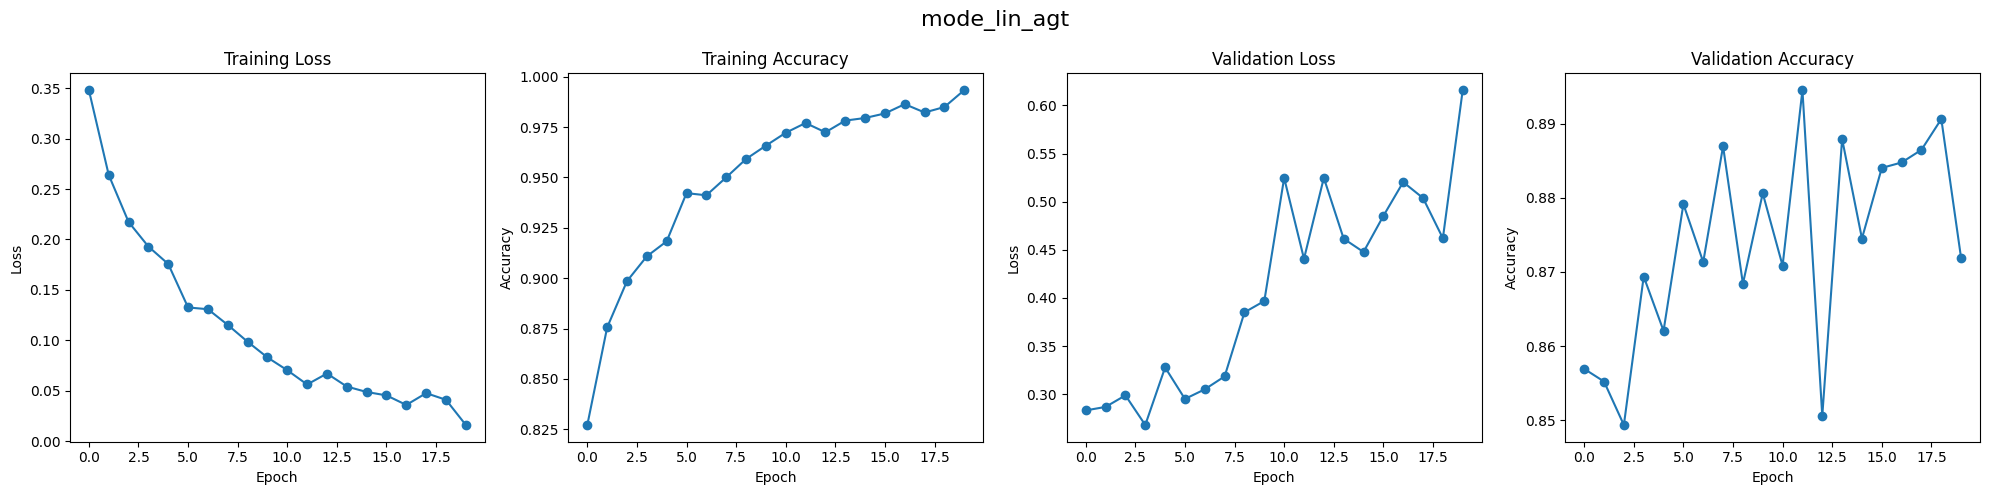

In [42]:
dropouts = np.linspace(0.5, 0.3, EPOCHS)
model = MLP(33, MLP_DIMS, dropout=dropouts[0]).to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

run_expt(model, optimizer, criterion, scheduler, dropouts, expt_name='mode_lin_agt')

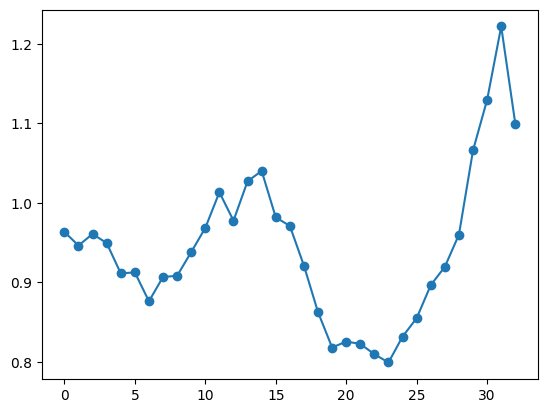

In [45]:
plt.plot(range(33), model.layer_weights.cpu().tolist(), marker='o', linestyle='-')

Train:   0%|                                                                                                                                                                                                                                                     | 0/66 [00:00<?, ?it/s]

66it [00:01, 37.99it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 42.65it/s, acc=82.7740%, loss=0.3547]
32it [00:00, 35.48it/s]███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 31/32 [00:01<00:00, 34.35it/s, acc=85.6934%, loss=0.2913]
66it [00:01, 37.91it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 42.63it/s, acc=87.7924%, loss=0.2562]
32it [00:00, 35.28it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

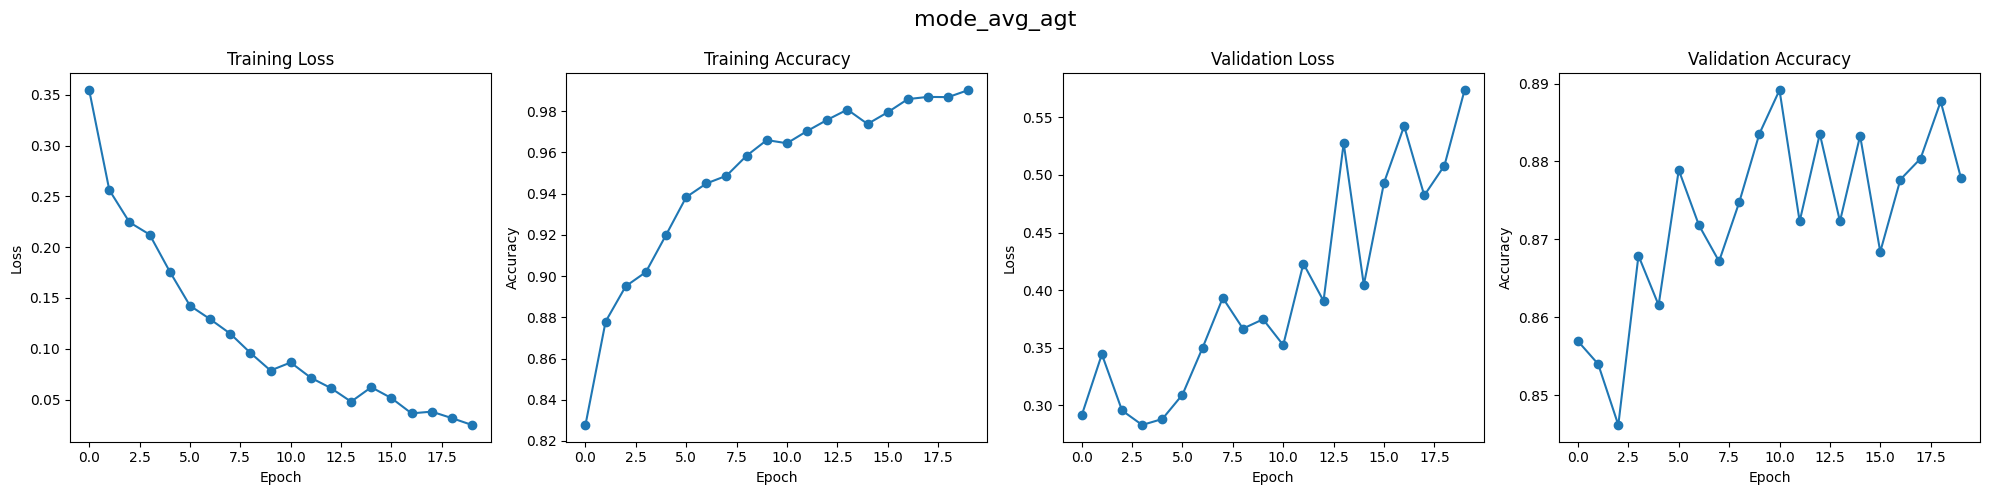

In [38]:
dropouts = np.linspace(0.5, 0.3, EPOCHS)
model = MLP(33, MLP_DIMS, dropout=dropouts[0], mode='avg_agt').to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

run_expt(model, optimizer, criterion, scheduler, dropouts, expt_name='mode_avg_agt')

Train:   0%|                                                                                                                                                                                                                                                     | 0/66 [00:00<?, ?it/s]

66it [00:01, 38.24it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 42.99it/s, acc=83.5199%, loss=0.3391]
32it [00:00, 35.63it/s]███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 31/32 [00:01<00:00, 34.51it/s, acc=86.7432%, loss=0.2739]
66it [00:01, 38.55it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 65/66 [00:02<00:00, 42.66it/s, acc=87.8758%, loss=0.2562]
32it [00:00, 35.55it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

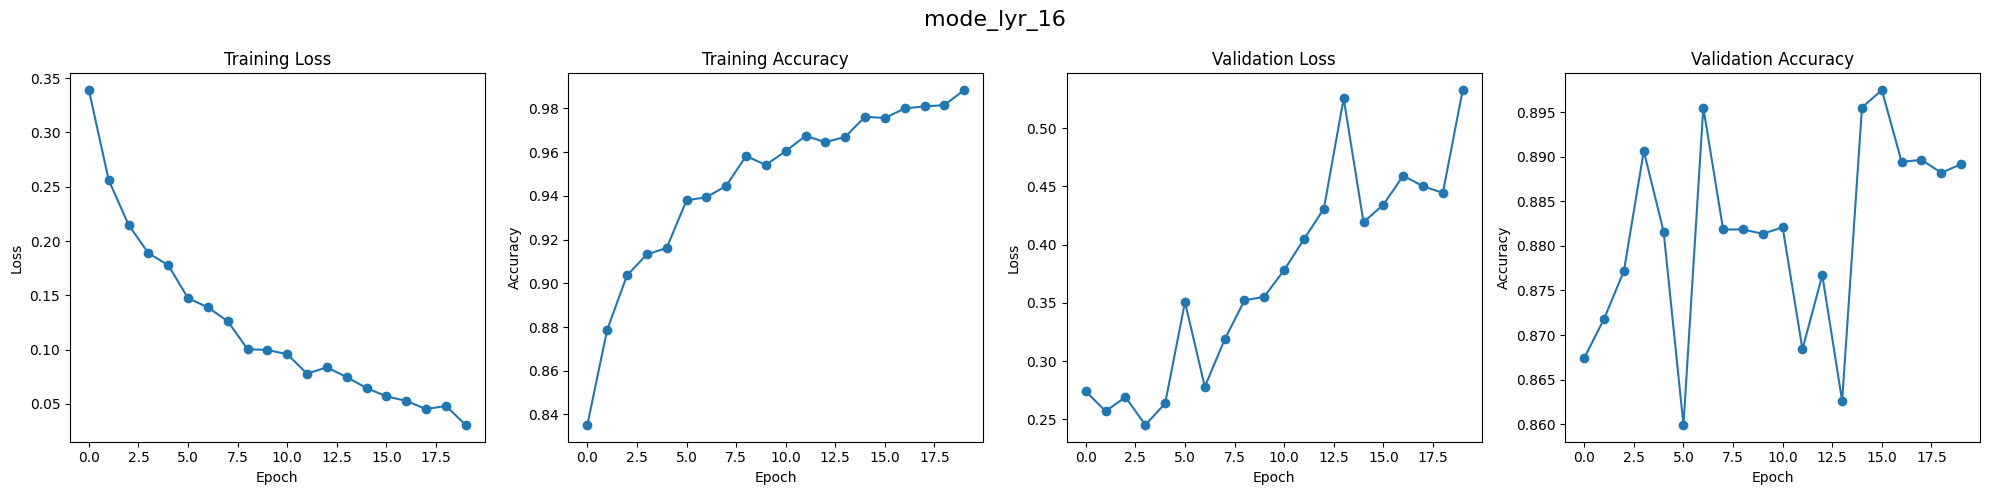

In [39]:
dropouts = np.linspace(0.5, 0.3, EPOCHS)
model = MLP(33, MLP_DIMS, dropout=dropouts[0], mode='lyr_16').to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

run_expt(model, optimizer, criterion, scheduler, dropouts, expt_name='mode_lyr_16')

66it [00:01, 38.32it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 65/66 [00:02<00:00, 42.87it/s, acc=70.0675%, loss=0.5235]
32it [00:00, 36.50it/s]███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 31/32 [00:01<00:00, 35.31it/s, acc=72.2900%, loss=0.5556]
66it [00:01, 38.62it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 43.02it/s, acc=76.8054%, loss=0.4360]
32it [00:00, 35.38it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

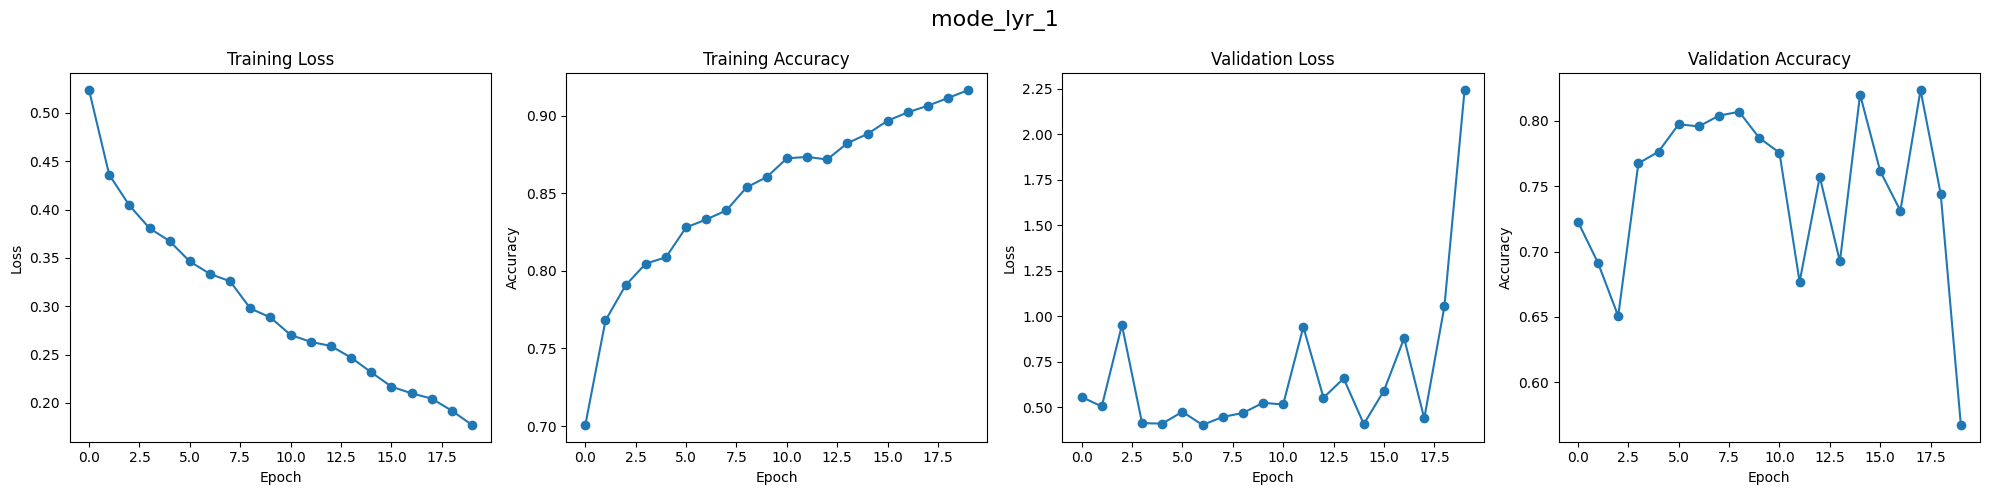

In [40]:
dropouts = np.linspace(0.5, 0.3, EPOCHS)
model = MLP(33, MLP_DIMS, dropout=dropouts[0], mode='lyr_1').to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

run_expt(model, optimizer, criterion, scheduler, dropouts, expt_name='mode_lyr_1')

66it [00:01, 37.82it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 65/66 [00:02<00:00, 42.14it/s, acc=82.0632%, loss=0.3611]
32it [00:00, 36.37it/s]███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 31/32 [00:01<00:00, 35.47it/s, acc=85.1318%, loss=0.2929]
66it [00:01, 38.12it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 65/66 [00:02<00:00, 42.73it/s, acc=87.0943%, loss=0.2705]
32it [00:00, 35.59it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

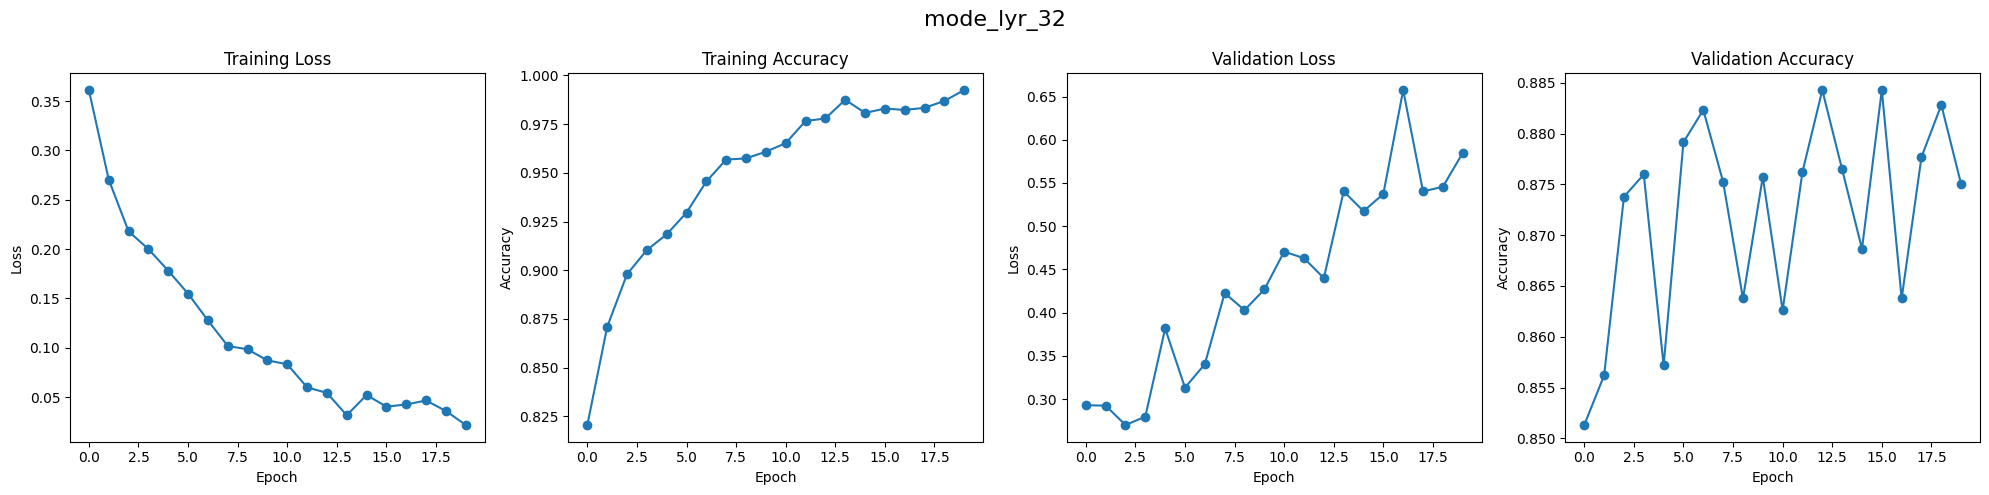

In [41]:
dropouts = np.linspace(0.5, 0.3, EPOCHS)
model = MLP(33, MLP_DIMS, dropout=dropouts[0], mode='lyr_32').to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

run_expt(model, optimizer, criterion, scheduler, dropouts, expt_name='mode_lyr_32')